In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import cPickle as pickle
import numpy as np

import pydensecrf.densecrf as dcrf
import pydensecrf.eigen as e
import copy

import os
import sys

from PIL import Image
from PIL import ImageDraw

### Prepare functions

In [3]:
# We use Theano to do average-filtering efficiently, but any other method can be used
from theano import *
import theano.tensor as T
from theano.sandbox.cuda import dnn

import theano
import pandas as pd
from theano import tensor as T
from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams
import numpy as np
import cPickle, gzip, numpy
from theano.tensor.nnet.conv import conv2d
from theano.tensor.signal.downsample import max_pool_2d
stride =8

kernel_size =T.scalar('size', dtype='int32')
in_img = T.tensor4('in', dtype='float64')
kernel = T.alloc(1.0,1,1,kernel_size,kernel_size)/(kernel_size*kernel_size)

H,W = in_img.shape[2:]

convolved = conv2d(in_img,kernel,border_mode = 'full',subsample =(stride,stride))[:,:,kernel_size//(2*stride):kernel_size//(2*stride)+H//stride,kernel_size//(2*stride):kernel_size//(2*stride)+W//stride]

convolution_function = theano.function(inputs=[in_img ,kernel_size], outputs=[ convolved ], updates=[], allow_input_downcast=True,on_unused_input='warn')


Using gpu device 0: GeForce GTX TITAN Z (CNMeM is disabled, cuDNN 5110)
/home/baque/.local/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
/home/baque/.local/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


### Functions

In [4]:
import scipy.signal
import copy


sxy_g=3 
compat_g=3
sxy_b=2
srgb=3
compat_b=10



def perform_inference_Lagrange(U,img_in,clamps,n_steps = 5,T = 1.0,verbose = False,step =1.0,N=1000,proportion = 0.5,returnKL = False):
    H,W = img_in.shape[:2]
    NC = U.shape[0]
    d = dcrf.DenseCRF2D(H, W, NC)
    
    T_i = T*2
    d.setUnaryEnergy(U/(T_i))
    d.addPairwiseGaussian(sxy=sxy_g, compat=compat_g/(T_i))
    d.addPairwiseBilateral(sxy=sxy_b, srgb=srgb, rgbim=img_in, compat=compat_b/(T_i))  
    
    #Initialise Q
    Q_out, tmp1, tmp2 = d.startInference()
    Q = np.asarray(Q_out)*0.0 + 1.0
    Q = np.exp(np.log(Q_out)*step +(1-step)*np.log(Q))
    Q = Q/ np.sum(Q,axis =0)
    
    #Initialise Lagrange multipliers
    Lambdas = np.zeros(len(clamps)) +1
    
    for i in range(n_steps):
        
                    
        ### Option 2
        HO_grad = 0#useless
        Lagrange_grad = get_Lagrange_grad(Lambdas,Q,clamps)
        if i == n_steps/5:
            T_i = T
            d = dcrf.DenseCRF2D(H, W, NC)
            d.addPairwiseGaussian(sxy=sxy_g, compat=compat_g/(T_i))
            d.addPairwiseBilateral(sxy=sxy_b, srgb=srgb, rgbim=img_in, compat=compat_b/(T_i))  
            
        
        d.setUnaryEnergy(U/T_i - Lagrange_grad)

        
        Q_out = copy.copy(Q.copy(order='C'))
        Q_out = e.matrixXf(Q_out)
        d.stepInference(Q_out, tmp1, tmp2)
        if verbose:
            print("KL-divergence at {}: {}".format(i, d.klDivergence(Q_out)))

        Q = np.exp(np.log(Q_out)*step +(1-step)*np.log(Q))
        Q = Q/ np.sum(Q,axis = 0)
        
        Lambdas = update_Lagrange(Lambdas,Q,clamps,proportion)
        
    #FIne tune without external
    for i in range(3):
        d.setUnaryEnergy(U/T_i)
        Q_out = copy.copy(Q.copy(order='C'))
        Q_out = e.matrixXf(Q_out)
        d.stepInference(Q_out, tmp1, tmp2)
        Q = np.asarray(Q_out)


    if returnKL:
        KL = d.klDivergence(Q_out)
        return np.asarray(Q_out).reshape((-1,H,W)),KL

    else:
        return np.asarray(Q_out).reshape((-1,H,W))


def update_Lagrange(Lambdas,Q,clamps,proportion ,Lambda_step = 5.0):
    for l,(variables,initial_values,sign) in enumerate(clamps):
        N = proportion*len(variables)
        q_neg = 1-Q[initial_values,variables]
        Lambdas[l] = np.clip(Lambdas[l] + Lambda_step *(N-np.sum(q_neg))/(len(variables)*1.0)*sign ,2.8,8.0)
    
    return Lambdas

def get_Lagrange_grad(Lambdas,Q,clamps,Lambda_step = 10):
    grad = 0.0*Q
    for l,(variables,initial_values,sign) in enumerate(clamps):
        #grad[:,variables] += Lambdas[l]*sign
        grad[initial_values,variables] += -1*Lambdas[l]*sign
    
    return grad




def select_variables_multiscale(Q_low,Q_high,clamps):

    indicators = 0.0*Q_low+1
    n_labels,H,W = Q_low.shape
    
    #Filter-out the ones which have low Q_low
    filter_low = Q_low<0.9
    indicators[filter_low] = 0.0
    
    #TEST, uncomment
    for (variables,initial_values,sign) in clamps:
        indicators[initial_values,variables/W,variables%W] =0.0

################
    
    
    #Compute change between low and high temp
    Tchange_perclass = (Q_low/Q_high-1)*indicators
    Tchange_perclass[Tchange_perclass>2] = 2

    #remove the border
    Tchange_perclass[:,0:20,:] =0
    Tchange_perclass[:,H-20:H,:] =0
    Tchange_perclass[:,:,0:20] =0
    Tchange_perclass[:,:,W-20:W] =0

    
    kernel_list =[(21,21),(51,51),(91,91),(151,151)]
    all_convolved = []
    Tchange_perclass_theano = Tchange_perclass.reshape((-1,1,H,W))
    
    #Show
    
    for k,(h_k,w_k) in enumerate(kernel_list):    
        convolved = np.asarray(convolution_function(Tchange_perclass_theano,h_k))[0,:,0,:,:]*(h_k*w_k)**(0.25)
        all_convolved.append(convolved)
              
    #Select window and label
    max_value = 0
    k = 0
    l, x_c, y_c =(0,0,0)
    for loc_k,(h_k,w_k) in enumerate(kernel_list):
        arg_index =np.argmax(all_convolved[loc_k])
        loc_l, loc_x_c, loc_y_c =np.unravel_index(arg_index, all_convolved[loc_k].shape)
                
        if all_convolved[loc_k][loc_l, loc_x_c, loc_y_c] > max_value:
            max_value = all_convolved[loc_k][loc_l, loc_x_c, loc_y_c]
            l, x_c, y_c = loc_l, loc_x_c, loc_y_c
            k = loc_k
        
    #Puting back to coordinates without stride
    x_c, y_c =  stride*x_c, stride*y_c
    
     
    MAP = np.argmax(Q_low, axis=0).reshape((H,W))
        
    #values
    x_0,y_0 = max(0,x_c-h_k/2),max(0,y_c-w_k/2)
    x_1,y_1 = min(H,x_c+h_k/2+1),min(W,y_c+w_k/2+1)
    
    initial_values = np.ndarray.flatten(MAP[x_0 :x_1, y_0 :y_1])
    
    #Indices
    y_variables = np.repeat(np.asarray(range(y_0 ,y_1)).reshape(y_1-y_0,1),x_1-x_0,axis =1)
    x_variables = np.repeat(W*np.asarray(range(x_0 ,x_1)).reshape(x_1-x_0,1),y_1-y_0,axis =1)
    xy_variables = x_variables +y_variables.T
    variables = np.ndarray.flatten(xy_variables)#[0:min(h_k,H - (x_c-h_k/2) ),0:min(w_k,W - (y_c-w_k/2))])
    
    #Now, only select the ones that initialy took label l
    variables = variables[initial_values==l]
    initial_values = initial_values[initial_values==l]
    
 
    return variables, initial_values,x_c,y_c,h_k,w_k


### Test

In [7]:
def add_clamplist(initial_clamplist,variables,initial_values,index):
    

    clamplist = copy.copy(initial_clamplist)
    l = len(clamplist)
    if l ==0:
        clamplist=[[(variables,initial_values,-1)],[(variables,initial_values,1)]]
    else:
        current_clamps = copy.copy(clamplist[index])
        del clamplist[index]
        clamplist.insert(index,current_clamps + [(variables,initial_values,-1)])
        clamplist.insert(index+1,current_clamps + [(variables,initial_values,1)])
    return clamplist

def run_example(n_nodes = 7):


    #Load unaries
    f = open('./data_example/%06d_unary.cpickle'%0, 'rb')
    in_unaries = pickle.load(f)
    f.close()
   
    in_unaries = np.squeeze(in_unaries)



    NC = in_unaries.shape[0]

    in_rgb_original =Image.open('./data_example/%06d_rgb.jpg'%0)

    #Test pyDenseCRF
    #Initialisation
    img_in =copy.copy(np.asarray(in_rgb_original))
    H,W = img_in.shape[:2]
    U = -1*in_unaries[:,:H,:W].reshape((NC,-1)) # Needs to be flat.
    U = U.copy(order='C')
    U[0,:] =U[0,:]



    #Loop
    index =0
    clamplist =[]

    for n in range(0,n_nodes):
        #print "Node # %02d"%n
        #print "clamplist", clamplist

        if len(clamplist)==0:
            Q_high = perform_inference_Lagrange(U,img_in,[],n_steps = 8,T=5.0,verbose=False,step =1.0)
            Q_low = perform_inference_Lagrange(U,img_in,[],n_steps = 8,T=1,verbose=False,step =1.0)
            variables, initial_values,x_c,y_c,h_k,w_k = select_variables_multiscale(Q_low,Q_high,[])
            MAP_0 = np.argmax(Q_low, axis=0).reshape((H,W))


        if len(clamplist)!=0:
            index = (index +2)%(len(clamplist))
            #print "Index", index,'len clamplist', len(clamplist)
            Q_high = perform_inference_Lagrange(U,img_in,clamplist[index],n_steps = 8,T=5.0,verbose=False,step =1.0)
            Q_low = perform_inference_Lagrange(U,img_in,clamplist[index],n_steps = 8,T=1,verbose=False,step =1.0)
            variables, initial_values,x_c,y_c,h_k,w_k = select_variables_multiscale(Q_low,Q_high,clamplist[index])


        clamplist = add_clamplist(clamplist,variables,initial_values,index)
        
    
    
    #Compute IU in final nodes
    
    Q_list = []
    MAP_list =[]
    for index in range(len(clamplist)):
        Q_low,KL = perform_inference_Lagrange(U,img_in,clamplist[index],n_steps = 8,T=1,verbose=False,step =1.0,returnKL=True)

        pred = np.argmax(Q_low, axis=0).reshape((H,W))

        MAP_list.append(pred)
        Q_list.append(Q_low)
            

    return MAP_list,Q_list


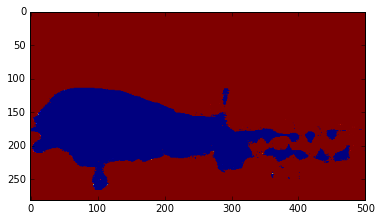

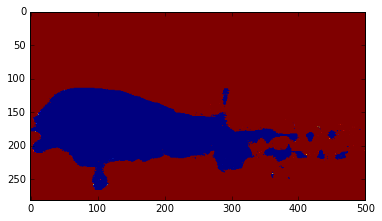

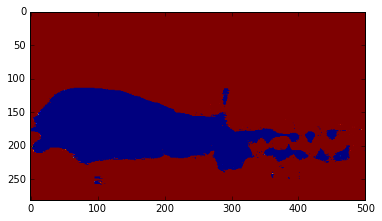

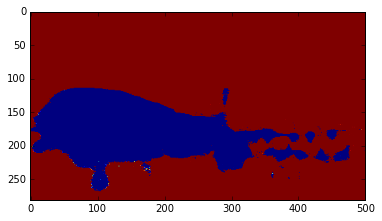

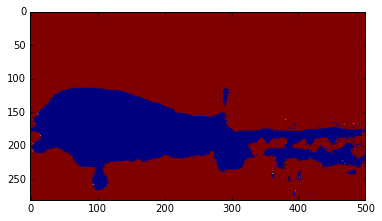

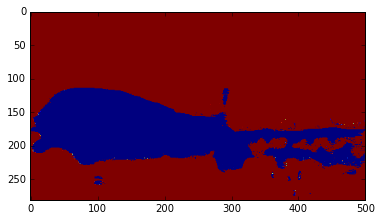

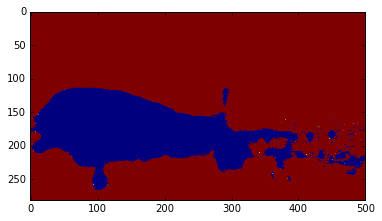

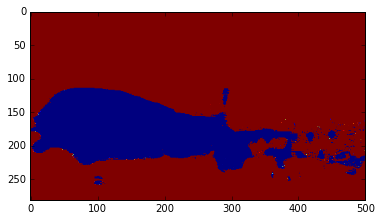

In [44]:
for m in range(8):
    plt.imshow(Q_list[m][0])
    plt.show()

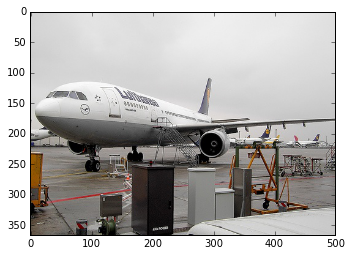

In [43]:

in_rgb_original =Image.open('./data_example/%06d_rgb.jpg'%0)

plt.imshow(in_rgb_original)
plt.show()
